In [1]:
import scipy.special
import shap
import numpy as np
import scipy
import itertools
import pandas as pd

c:\Users\shoei\miniconda3\envs\levshap_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


データセットのダウンロード

In [2]:
dataset_loaders = {
    "Adult": shap.datasets.adult,
    "California": shap.datasets.california,
    "Communities": shap.datasets.communitiesandcrime,
    "Correlated": shap.datasets.corrgroups60,
    "Diabetes": shap.datasets.diabetes,
    "Independent": shap.datasets.independentlinear60,
    "IRIS": shap.datasets.iris,
    "NHANES": shap.datasets.nhanesi,
}

In [3]:
def load_dataset(dataset_name):
    X, y = dataset_loaders[dataset_name]()
    # Remove nan values
    X = X.fillna(X.mean())
    return X, y


In [4]:
import xgboost as xgb

X, y = load_dataset("Adult") # すべてのデータセットで動いた
n = X.shape[1] # 特徴量数
# Assuming deterministic
model = xgb.XGBRegressor(n_estimators=100, max_depth=4)
model.fit(X, y) # 説明対象モデルを訓練

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [5]:
type(X)

pandas.core.frame.DataFrame

In [6]:
# X:データセットの特徴量(load_datasetで取得したX)
def load_input(X, seed=None, is_synthetic=False):
    if is_synthetic:
        baseline = np.zeros((1, X.shape[1]))  # すべての特徴量が0（存在しない）のベースライン
        explicand = np.ones((1, X.shape[1]))  # すべての特徴量が1（存在する存在する）の説明対象
        return baseline, explicand
    if seed is not None:
        np.random.seed(seed)
    baseline = X.mean().values.reshape(
        1, -1
    )  # 各特徴量の平均値をベースラインとして使用。.reshape(1, -1)で1行n列 の2次元配列に整形
    explicand_idx = np.random.choice(X.shape[0])  # 説明対象のインデックスをランダムに選択
    explicand = X.iloc[explicand_idx].values.reshape(1, -1)  # 説明対象の行の特徴量を取得
    for i in range(explicand.shape[1]):  # 説明対象のインスタンスの各特徴量について
        # baseline と explicandが各特徴量ごとに必ず異なる値を持つよう保証する
        # SHAP 等の説明手法では、ベースラインとの差分を計算するため、ある特徴量でベースラインと同値だと説明が得られない（差分が 0）というケースを避けたい、という意図がある
        while baseline[0, i] == explicand[0, i]:
            explicand_idx = np.random.choice(X.shape[0])
            explicand[0, i] = X.iloc[explicand_idx, i]
    return baseline, explicand


In [11]:
baseline, explicand = load_input(X, seed=0, is_synthetic=False)
baseline


array([[3.85816460e+01, 3.86889223e+00, 1.00806789e+01, 2.61183625e+00,
        6.57274039e+00, 2.49451798e+00, 3.66585793e+00, 6.69205491e-01,
        1.07764880e+03, 8.73038330e+01, 4.04374542e+01, 3.67188661e+01]])

1インスタンス分の説明を生成

In [7]:
is_small = 2**n <= 1e7

In [8]:
# Compute the true SHAP values (assuming tree model)
def official_tree_shap(baseline, explicand, model, num_samples):
    # Suppress warning only for this function
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning)
    explainer = shap.TreeExplainer(model, baseline)
    shap_values = explainer.shap_values(explicand)
    # Re-enable warnings
    warnings.filterwarnings("default", category=UserWarning)
    return shap_values

In [9]:
# コード内では以下のように呼び出す

# Compute the true SHAP values (assuming tree model)
# true_shap_values = estimators['Official Tree SHAP'](baseline, explicand, model, sample_size).flatten()

# leverageshap\estimators\__init__.pyにて以下のように定義されているためこれが可能
# estimators = {
#     #    'Monte Carlo': monte_carlo,
#     #    'Matrix SHAP': matrix_shap,
#     #    'Matrix SHAP wo Bernoulli': matrix_shap_wo_bernoulli,
#     #    'Matrix SHAP wo Bernoulli, Paired': matrix_shap_wo_bernoulli_paired,
#     "Kernel SHAP": kernel_shap,
#     "Optimized Kernel SHAP": official_kernel_shap,
#     "Leverage SHAP": leverage_shap,
#     "Kernel SHAP Paired": kernel_shap_paired,
#     #    'Leverage SHAP wo Bernoulli': leverage_shap_wo_bernoulli,
#     #    'Leverage SHAP wo Bernoulli, Paired': leverage_shap_wo_bernoulli_paired,
#     "Official Tree SHAP": official_tree_shap,
#     "Leverage SHAP (Unpaired)": leverage_shap_wo_paired,
#     "Permutation SHAP": official_permutation_shap,
# }

In [10]:
import numpy as np
import scipy
import scipy.special
import math


def ith_combination(pool, r, index):
    # Function written by ChatGPT
    """
    pool の要素からちょうど r 個を 辞書順で選ぶとき、
    “index 番目” の組合せのみを直接計算する関数。全組合せを列挙せずに高速に取得できる。
    """
    n = len(pool)
    combination = []
    elements_left = n
    k = r
    start = 0

    for i in range(r):
        # Find the largest value for the first element in the combination
        # that allows completing the remaining k-1 elements
        for j in range(start, elements_left):
            count = math.comb(elements_left - j - 1, k - 1)
            if index < count:
                combination.append(pool[j])
                k -= 1
                start = j + 1
                break
            index -= count

    return tuple(combination)


def combination_generator(gen, n, s, num_samples):
    """
    Generate num_samples random combinations of s elements from a pool num_samples of size n in two settings:
    1. If the number of combinations is small (converting to an int does NOT cause an overflow error), randomly sample num_samples integers without replacement and generate the corresponding combinations on the fly with ith_combination.
    2. If the number of combinations is large (converting to an int DOES cause an overflow error), randomly sample num_samples combinations directly with replacement.
    """
    num_combos = math.comb(n, s)
    try:
        indices = gen.choice(num_combos, num_samples, replace=False)
        for i in indices:
            yield ith_combination(range(n), s, i)
    except OverflowError:
        for _ in range(num_samples):
            yield gen.choice(n, s, replace=False)


class RegressionEstimator:
    def __init__(
        self, model, baseline, explicand, num_samples, paired_sampling=False, leverage_sampling=False, bernoulli_sampling=False
    ):
        self.model = model
        self.baseline = baseline
        self.explicand = explicand  # そのままのデータ
        # Subtract 2 for the baseline and explicand and ensure num_samples is even
        self.num_samples = int((num_samples - 2) // 2) * 2  # 必ず偶数にする
        self.paired_sampling = paired_sampling  # 部分集合の補集合も合わせてサンプリング
        self.n = self.baseline.shape[1]  # Number of features
        self.gen = np.random.Generator(np.random.PCG64())
        self.sample_weight = lambda s: 1 / (s * (self.n - s)) if not leverage_sampling else np.ones_like(s) # leverage_sampling=True の場合はすべての部分集合サイズに対して同じ重みを与える
        self.reweight = lambda s: 1 / (self.sample_weight(s) * (s * (self.n - s)))
        self.kernel_weights = []
        self.sample = self.sample_with_replacement if not bernoulli_sampling else self.sample_without_replacement
        # self.used_indices = set()

    def add_one_sample(self, idx, indices, weight):
        """特徴量の組み合わせを作成し、重みも追加"""
        # indices = sorted(indices)
        # if tuple(indices) in self.used_indices: return
        # self.used_indices.add(tuple(indices))
        if not self.paired_sampling:
            self.SZ_binary[idx, indices] = 1
            self.kernel_weights.append(weight)
        else:
            indices_complement = np.array([i for i in range(self.n) if i not in indices])  # 補集合
            self.SZ_binary[2 * idx, indices] = 1
            self.kernel_weights.append(weight)
            self.SZ_binary[2 * idx + 1, indices_complement] = 1  # 補集合
            self.kernel_weights.append(weight)

    def sample_with_replacement(self):
        self.SZ_binary = np.zeros((self.num_samples, self.n))
        valid_sizes = np.array(list(range(1, self.n)))
        prob_sizes = self.sample_weight(valid_sizes)  # サイズに応じて重みづけ（leverage_sampling=Falseなら）
        prob_sizes = prob_sizes / np.sum(prob_sizes)
        num_sizes = self.num_samples if not self.paired_sampling else self.num_samples // 2  # paired_samplingは半分にする
        sampled_sizes = self.gen.choice(valid_sizes, num_sizes, p=prob_sizes)  # 各サイズからサンプリングする数を決定
        for idx, s in enumerate(sampled_sizes):
            indices = self.gen.choice(self.n, s, replace=False)  # 1インスタンスからs個の特徴量をサンプリング（重複なし）
            # weight = Pr(sampling this set) * w(s)
            weight = 1 / (self.sample_weight(s) * s * (self.n - s))
            self.add_one_sample(idx, indices, weight=weight)

    def find_constant_for_bernoulli(self, max_C=1e10):
        """Bernoulli Sampling のオーバーサンプリング定数 C を二分探索で決定する。
        目的：各部分集合サイズ s に対して min(1, 2*C*weight(s)) でサンプリングしたときのサンプル数の期待値が m になるように C を探す。

        Args:
            max_C (_type_, optional): _description_. Defaults to 1e10.

        Returns:
            _type_: _description_
        """
        # Choose C so that sampling without replacement from min(1, C*prob) gives the same expected number of samples
        C = 1  # Assume at least n - 1 samples
        m = min(self.num_samples, 2**self.n - 2)  # Maximum number of samples is 2^n -2

        def expected_samples(C):
            """定数 C のときに得られるサンプル数の期待値を返す。"""
            # scipy.special.binom(self.n, s) is the number of combinations of n choose s
            expected = [min(scipy.special.binom(self.n, s), 2 * C * self.sample_weight(s)) for s in range(1, self.n)]
            # print(f'Expected samples: {np.sum(expected)}')
            # print(f'Constraint: {m}')
            # print(f'C: {C}')
            return np.sum(expected)

        # Efficiently find C with 二分探索
        L = 1
        R = scipy.special.binom(self.n, self.n // 2) * self.n**2
        while round(expected_samples(C)) != m:  # 期待値がピッタリ m になるまでループ
            if expected_samples(C) < m:
                L = C  # 期待値が小さければ C を大きくする
            else:
                R = C  # 期待値が大きければ C を小さくする
            C = (L + R) / 2
        self.C = round(C)

    def sample_without_replacement(self):
        """
        サンプリング without replacement（置換なし）を実行し、
        self.SZ_binary に二値マトリックス（どの特徴量を
        ON にしたか）と対応する重みを格納する。
        """
        self.find_constant_for_bernoulli()  # オーバーサンプリング定数 C を決定する

        # 各部分集合サイズ s=1…n-1 について、実際に何個サンプリングするかを決定
        m_s_all = []
        for s in range(1, self.n):
            # Sample from Binomial distribution with (n choose s) trials and probability min(1, C*sample_weight(s) / (n choose s))
            prob = min(1, 2 * self.C * self.sample_weight(s) / scipy.special.binom(self.n, s))  # Bernoulli の成功確率
            try:
                m_s = self.gen.binomial(
                    int(scipy.special.binom(self.n, s)), prob
                )  # 二項分布(ベルヌーイ試行をたくさん繰り返したときに、「成功」が何回起きるか)でサンプル数を得る
            except OverflowError:  # If the number of samples is too large, assume the number of samples is the expected number
                m_s = int(prob * scipy.special.binom(self.n, s))  # 期待値を使う
            if self.paired_sampling:
                if s == self.n // 2:  # Already sampled all larger sets with the complement
                    if self.n % 2 == 0:  # Special handling for middle set size if n is even
                        # n が偶数かつ中央サイズなら、重複してサンプリングしないよう半分に
                        m_s_all.append(m_s // 2)
                    else:
                        m_s_all.append(m_s)
                    break
            m_s_all.append(m_s)
        sampled_m = np.sum(m_s_all)
        num_rows = sampled_m if not self.paired_sampling else sampled_m * 2
        self.SZ_binary = np.zeros((num_rows, self.n))
        idx = 0
        for s, m_s in enumerate(m_s_all):
            """
            各部分集合サイズsについて、事前に決めたサンプル数𝑚_s分だけ、combination_generator で「どの特徴量を選ぶか」の組合せを生成し、
            その組合せを二値マスク（self.SZ_binary の行）として格納かつ対応する重み weight を add_one_sample で設定
            """
            s += 1
            prob = min(1, 2 * self.C * self.sample_weight(s) / scipy.special.binom(self.n, s))
            weight = 1 / (prob * scipy.special.binom(self.n, s) * (self.n - s) * s)
            if self.paired_sampling and s == self.n // 2 and self.n % 2 == 0:  # ペア付きかつ中央サイズの時
                # n-1 個から (s-1) 個を選ぶ組合せを生成し、最後に要素 n-1 を追加
                combo_gen = combination_generator(self.gen, self.n - 1, s - 1, m_s)
                for indices in combo_gen:
                    # indices = 特徴量の組み合わせ
                    self.add_one_sample(idx, list(indices) + [self.n - 1], weight=weight)
                    idx += 1
            else:
                # 通常の組合せ生成：0...n-1 から s 個選ぶ
                combo_gen = combination_generator(self.gen, self.n, s, m_s)
                for indices in combo_gen:
                    self.add_one_sample(idx, list(indices), weight=weight)
                    idx += 1

    def compute(self):
        """
        SHAP値を計算する。main関数

        """
        # Sample
        self.sample()
        # A = Z P
        # y = v(z) - v0
        # b = y - Z1 (v1 - v0) / n
        # (A^T S^T S A)^-1 A^T S^T S b + (v1 - v0) / n
        # (P^T Z^T S^T S Z P)^-1 P^T Z^T S^T S b + (v1 - v0) / n

        # Remove zero rows
        SZ_binary = self.SZ_binary[np.sum(self.SZ_binary, axis=1) != 0]
        # 基準値 v0 と対象値 v1 をモデルから予測
        # baseline: すべてのインスタンスで各特徴量での平均値の特徴量入力
        # explicand: 説明対象のインスタンスそのままの特徴量入力
        v0, v1 = self.model.predict(self.baseline), self.model.predict(self.explicand)
        # mask が1なら explicand の特徴量、0なら baseline の特徴量を選ぶ
        inputs = self.baseline * (1 - SZ_binary) + self.explicand * SZ_binary
        Sy = self.model.predict(inputs) - v0
        SZ_binary1 = np.sum(SZ_binary, axis=1)

        Sb = Sy - (v1 - v0) * SZ_binary1 / self.n

        # Projection matrix
        P = np.eye(self.n) - 1 / self.n * np.ones((self.n, self.n))

        PZSSb = P @ SZ_binary.T @ np.diag(self.kernel_weights) @ Sb
        PZSSZP = P @ SZ_binary.T @ np.diag(self.kernel_weights) @ SZ_binary @ P
        PZSSZP_inv_PZSSb = np.linalg.lstsq(PZSSZP, PZSSb, rcond=None)[0]

        self.phi = PZSSZP_inv_PZSSb + (v1 - v0) / self.n

        return self.phi


In [11]:
def leverage_shap(baseline, explicand, model, num_samples):
    estimator = RegressionEstimator(
        model, baseline, explicand, num_samples, paired_sampling=True, leverage_sampling=True, bernoulli_sampling=True
    )
    return estimator.compute()


In [17]:
def official_kernel_shap(baseline, explicand, model, num_samples):
    eval_model = lambda X: model.predict(X)

    explainer = shap.KernelExplainer(eval_model, baseline)
    shap_values = explainer.shap_values(explicand, nsamples=num_samples, silent=True, l1_reg=False)
    return shap_values

In [12]:
# 説明の計算のためにベースラインと説明対象を取得
baseline, explicand = load_input(X)

num_samples = 2*n # 2*n以上ないとエラーになる

In [13]:
phi_est = leverage_shap(baseline, explicand, model, num_samples)
phi_est


array([ 0.00286001,  0.06945772,  0.08884938, -0.0073002 ,  0.07114636,
        0.32380782,  0.10052532, -0.0747688 ,  0.00979341,  0.01917269,
        0.00906676,  0.01232719])

In [19]:
phi_est_kernel = official_kernel_shap(baseline, explicand, model, num_samples)
phi_est_kernel


array([[ 0.03149761,  0.09530986, -0.00115963, -0.03479139,  0.21710004,
         0.40683248,  0.1078159 ,  0.00771402, -0.06296405, -0.01542803,
        -0.09417154, -0.03281761]])

In [18]:
# 正解値を計算
phi_true = official_tree_shap(baseline, explicand, model, num_samples).flatten()
phi_true

array([ 0.00849117, -0.00417934,  0.00334641,  0.        ,  0.09481128,
        0.37444445,  0.04440573,  0.        ,  0.06363591,  0.        ,
        0.03940801,  0.000574  ])

In [15]:
error = np.sum((phi_true - phi_est) ** 2)
error


np.float64(0.02900739461926386)

ちゃんと実装できているかcheck

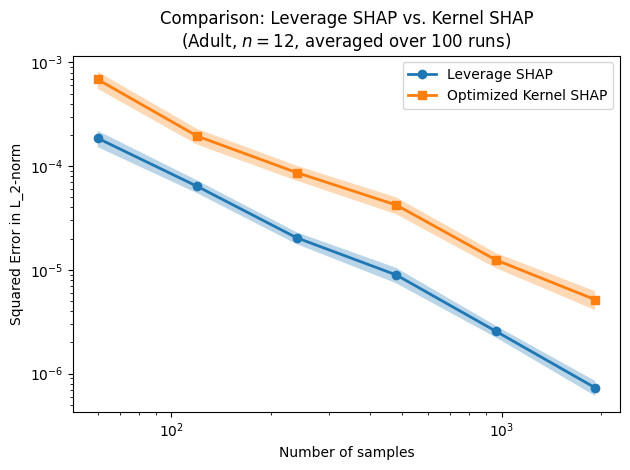

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare sample sizes (multiples of n)
ms = [5 * n, 10 * n, 20 * n, 40 * n, 80 * n, 160 * n]
num_runs = 100

# 誤差格納用
lev_errors = np.zeros((num_runs, len(ms)))
ker_errors = np.zeros((num_runs, len(ms)))

for run in range(num_runs):
    # 毎回別のテストインスタンスを取得
    baseline_run, explicand_run = load_input(X, seed=run)
    for j, m in enumerate(ms):
        # --- Leverage SHAP ---
        phi_lev = leverage_shap(baseline_run, explicand_run, model, m)
        # --- Kernel SHAP ---
        phi_ker = official_kernel_shap(baseline_run, explicand_run, model, m).flatten()
        # --- Ground truth (TreeSHAP) ---
        phi_true = official_tree_shap(baseline_run, explicand_run, model, m).flatten()

        # 二乗誤差を計算
        lev_errors[run, j] = np.sum((phi_true - phi_lev) ** 2)
        ker_errors[run, j] = np.sum((phi_true - phi_ker) ** 2)

# 平均・標準誤差を算出
lev_mean = lev_errors.mean(axis=0)
lev_sem = lev_errors.std(axis=0) / np.sqrt(num_runs)
ker_mean = ker_errors.mean(axis=0)
ker_sem = ker_errors.std(axis=0) / np.sqrt(num_runs)

# ==== プロット ====
fig, ax = plt.subplots()

# Leverage SHAP
ax.plot(ms, lev_mean, marker="o", label="Leverage SHAP", linewidth=2)
ax.fill_between(ms, lev_mean - lev_sem, lev_mean + lev_sem, alpha=0.3)

# Kernel SHAP
ax.plot(ms, ker_mean, marker="s", label="Optimized Kernel SHAP", linewidth=2)
ax.fill_between(ms, ker_mean - ker_sem, ker_mean + ker_sem, alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples")
ax.set_ylabel("Squared Error in L_2-norm")
ax.set_title("Comparison: Leverage SHAP vs. Kernel SHAP\n(Adult, $n={}$, averaged over {} runs)".format(n, num_runs))
ax.legend()

plt.tight_layout()
plt.show()

<!-- 横幅を400pxに固定 -->
<img src="leverage_shap_adult.png" alt="Leverage SHAP" width="700"/>